In [1]:
# Dylan Kriegman
# May 2023

In [1]:
import pyrealsense2 as rs
import open3d as o3d
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Debug)
import numpy as np
import math
import cv2 as cv
import scipy.ndimage as nd
# Used to display Matplotlib plots in Jupyter
# %matplotlib inline
import matplotlib.pyplot as plt
import time

# PIL used to save images as pngs"
from PIL import Image

# Robotics Toolbox used to determine camera coordinate frame given joint angles
import roboticstoolbox as rtb

# Spatial Math is used for manipulating geometric primitives
import spatialmath as sm
from spatialmath import SE3

# Poses is from rmlib and used for converting between 4 x 4 homogenous pose and 6 element vector representation (x,y,z,rx,ry,rz)
import poses
 
import copy

import swift

from spatialgeometry.geom.CollisionShape import (CollisionShape,Mesh,Cylinder,Cuboid,Box,Sphere)

import spatialgeometry as sg

# UR Interface
import rtde_control
import rtde_receive

# Gripper Interface 
from Motor_Code import Motors

# For insterfacing with fast downward solver
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class UR5_Interface():
    def __init__(self):
        self.robotIP = "192.168.0.6"
        # RTDEControlInterface and RTDEReceiveInterface Objects
        self.c,self.r = None,None
        # Gripper Controller Interface
        self.gripperController = None

    def getJointAngles(self):
        # Returns a 6 element numpy array of joint angles (radians)
        thetas = np.array(self.r.getActualQ())
        return thetas
    
    def getPose(self):
        # Returns the current pose of the last frame as a SE3 Object (4 x 4 Homegenous Transform)
        p = self.r.getActualTCPPose() 
        poseMatrix = self.poseVectorToMatrix(p)
        T_N = sm.SE3(poseMatrix)
        # T_N.plot(name="C")
        return T_N

    
    def poseVectorToMatrix(self,poseVector):
        # Converts poseVector into an SE3 Object (4 x 4 Homegenous Transform)
        # poseVector is a 6 element list of [x, y, z, rX, rY, rZ]
        T_N = sm.SE3(poses.pose_vec_to_mtrx(poseVector))
        return T_N
    
    def poseMatrixToVector(self,poseMatrix):
        # Converts poseMatrix into a 6 element list of [x, y, z, rX, rY, rZ] 
        # poseMatrix is a SE3 Object (4 x 4 Homegenous Transform) or numpy array
        return poses.pose_mtrx_to_vec(np.array(poseMatrix))
        
    
    def moveJ(self,qGoal):
        # qGoal is a 6 element numpy array of joint angles (radians)
        # speed is joint velocity (rad/s)
        qGoal = list(qGoal)
        print(f"MoveJ to:\n {np.degrees(qGoal).reshape((6,1))}")
        self.c.moveJ(qGoal,1.05,1.4,True)
    
    def moveL(self,poseMatrix):
        # poseMatrix is a SE3 Object (4 x 4 Homegenous Transform) or numpy array
        # Moves tool tip pose linearly in cartesian space to goal pose (requires tool pose to be configured)
        # tool pose defined relative to the end of the gripper when closed
        poseVector = self.poseMatrixToVector(poseMatrix)
        self.c.moveL(poseVector, 0.25, 0.5, False)
        
        
    def moveHome(self):
        # Moves the arm linearly in cartesian space to home pose
        homePose = np.array([[ 0.99955322, -0.02418213, -0.01756664,  0.01498893],
                             [-0.01748495,0.00358545,-0.9998407,-0.57686779],
                             [0.02424126,0.99970114,0.00316103,0.05545535],
                             [0,0,0,1]])
        self.arm.move(target=homePose,move_type="l")
    
    def openGripper(self):
        self.gripperController.openGripper()
        
    def closeGripper(self,width=10):
        # Computes the servo angles needed for the jaws to be width mm apart
        # Sends command over serial to the gripper to hold those angles
        dTheta = self.gripperController.distance2theta(width)
        self.gripperController.position(dTheta)
        
        
    def testRoutine(self):
        # Moves ur +1 cm in world frame z-axis then down 1 cm and then opens, closes, and opens gripper  
        print("Running Test Routine")
        initPose = np.array(self.getPose())
        # print(f"TCP Pose:\n{initPose}")
        dX,dY,dZ = 0,0,2/100 # in m
        goalPose = initPose
        goalPose[2][3] += dZ
        goalPose = sm.SE3(goalPose)
        # print(f"Goal TCP Pose:\n{goalPose}")
        print("Running UR Test")
        self.moveL(sm.SE3(goalPose))
        # print(f"Final TCP Pose:\n{self.getPose()}")
        goalPose = np.array(self.getPose())
        goalPose[2][3] -= dZ
        goalPose = sm.SE3(goalPose)
        self.moveL(goalPose)
        print("Running Gripper Test")
        # print("Opening Gripper")
        self.openGripper()
        time.sleep(1)
        self.closeGripper(10)
        time.sleep(2)
        self.openGripper()


In [3]:
# Call this once to intialize serial connections to ur and gripper
# To list serial ports of the motor interface
# $ python -m serial.tools.list_ports
'''
robotIP = "192.168.0.6"
con = rtde_control.RTDEControlInterface(robotIP)
rec = rtde_receive.RTDEReceiveInterface(robotIP)
servoPort = "/dev/ttyACM0"
gripperController = Motors(servoPort)
gripperController.torquelimit(600)
'''

'\nrobotIP = "192.168.0.6"\ncon = rtde_control.RTDEControlInterface(robotIP)\nrec = rtde_receive.RTDEReceiveInterface(robotIP)\nservoPort = "/dev/ttyACM0"\ngripperController = Motors(servoPort)\ngripperController.torquelimit(600)\n'

In [4]:
# con.disconnect()
# rec.disconnect()

In [5]:
# Runs test routine, moves ur and then open and closes gripper 
'''
try:
    ur = UR5_Interface()
    ur.c,ur.r,ur.gripperController = con,rec,gripperController
    ur.testRoutine()
    
    
except Exception as e:
    raise(e)
finally:
    pass
    # ur.c.disconnect()
    # ur.r.disconnect()
'''

'\ntry:\n    ur = UR5_Interface()\n    ur.c,ur.r,ur.gripperController = con,rec,gripperController\n    ur.testRoutine()\n    \n    \nexcept Exception as e:\n    raise(e)\nfinally:\n    pass\n    # ur.c.disconnect()\n    # ur.r.disconnect()\n'

In [6]:
class RTB_Model():
    # Kinematic Model of the Robot in the Robotics Toolbox for Python (RTB)
    # Not really needed but helpful for visualization / testing
    def __init__(self):
        # Model has units in meters
        self.ur5_DH = rtb.models.DH.UR5() # URDF model
        self.ur5_URDF = rtb.models.UR5() # DH parameter-based model 

        homeJointAngles = np.array(np.radians([53,-112,144,-27.5,55,171.7]))
        self.setJointAngles(homeJointAngles)
        
    def setJointAngles(self,thetas):
        # thetas: 6 x 1 numpy array of joint angles (radians)
        self.ur5_DH.q = thetas
        self.ur5_URDF.q = thetas
        
    def initSwiftEnv(self):
        self.swiftEnv = swift.Swift()
        self.swiftEnv.launch()
        self.swiftEnv.add(self.ur5_URDF)
        endEffectorFrame = self.ur5_DH.fkine_all(self.ur5_DH.q)[-1] * SE3()
        endEffectorFrame.t[0:2] *= -1
        axes = sg.Axes(length=0.5,pose=endEffectorFrame)
        self.swiftEnv.add(axes)
        
    def addSwiftBox(self,pos,dims=(0.01905,0.01905,0.01905)):
        # Swift Model seems to have a different coordinate system than the DH model
        # The x-axis and y-axis point in the opposite direction as the DH model
        # pos is tuple of (x,y,z)
        # dims is tuple of (length,width,height)
        box = Cuboid(dims,pose=SE3(-pos[0],-pos[1],pos[2]))
        self.swiftEnv.add(box)

    def simulateSwiftRobot(self):
        T = np.eye(4)
        T[0:3,3] = np.array([0,0.25,0.25]).T
        print(T)
        sol = self.ur5_URDF.ikine_LMS(SE3(T)) # Solve IK to get fgoal pose
        print(sol)
        qtraj = rtb.jtraj(self.ur5_URDF.q,sol.q,50)
        dt = 0.05
        self.swiftEnv.start_recording("ur5",1/dt)
        for qk in qtraj.q:
            print(qk)
            self.setJointAngles(qk) # update robot state
            self.swiftEnv.step(dt) # update visualization
        self.swiftEnv.stop_recording()
        # dt = 0.050
    
    def plotRobot(self):
        # Displays DH robot in matplotlib
        ur5 = self.ur5_DH
        env = ur5.plot(ur5.q) # PyPlot backend

        
        # env.ax.scatter([0,0],[0,0],[0.4,0.45])
        # T_C = self.getCameraFrame()
        # T_C.plot(frame="C",length=0.1)
        # env.hold()
    
    def getGripperPose(self):
        # Returns the pose (4 x 4 Homogenous Transform as SE3 Spatial Math Object) with position in the center between the 2 gripper links
        ur5 = self.ur5_DH
        T_N = ur5.fkine_all(ur5.q)[-1] # T_N - end-effector frame (before optoforce/gripper)
        d = 0.1125 # distance between end-effector frame origin and center of gripper frame along z-axis (m)
        T_G = T_N * SE3.Tz(d)
        return T_G
    
    def getCameraFrame(self):
        # Robot joint angles need to be set pior 
        # Returns a SE3 Spatial Math Object (4 x 4 Homogenous Transform) corresponding to the robot's camera frame 
        ur5 = self.ur5_DH
        T_N = ur5.fkine_all(ur5.q)[-1] # T_N - end-effector frame (before optoforce/gripper)
        d = 0.292 # distance between end-effector frame origin and center of camera frame along z-axis (m)
        P_C = np.array([0,0,d]) # Translation from frame T_N to origin of camera frame (m)
        theta = np.radians(90) # Rotation about the Z-axis between the camera frame and end-effector frame
        T_C = T_N * SE3.Tz(d) * SE3.Rz(theta) # Camera coordinate frame
        return T_C

In [7]:
# r = RTB_Model()
# r.getCameraFrame()
# r.initSwiftEnv()
# r.addSwiftBox([0,0,0.5])
# r.simulateSwiftRobot()

In [8]:
class RealSense():
    def __init__(self,zMax = 0.5,voxelSize = 0.001):
        self.pinholeIntrinsics = None # set in self.takeImages()
        self.zMax = zMax # max distance for objects in depth images (m)
        # downsample point cloud with voxel size = 1 mm (0.001 m / 0.04 in)
        self.voxelSize = voxelSize
        self.pcd = o3d.geometry.PointCloud() # current pcd from realsense
        self.extrinsics = np.eye(4) # extrinsic parameters of the camera frame 4 x 4 numpy array
        self.cameraFrameTransform = np.eye(4)
        self.pipe,self.config = None,None
    
    def initConnection(self):
        # Initializes connection to realsense, sets pipe,config values
        self.pipe = rs.pipeline()
        self.config = rs.config()

        # Getting information about the connected realsense model (device object) - D405
        pipeProfile = self.config.resolve(rs.pipeline_wrapper(self.pipe))
        device = pipeProfile.get_device()
        depth_sensor = device.first_depth_sensor()
        self.depthScale = depth_sensor.get_depth_scale()
        # print(depth_scale)

        # 1 - default, 2 - hand, 3 - high accuracy, 4 - high density, 5 - medium density
        depth_sensor.set_option(rs.option.visual_preset,4) # 4 corresponds to high-density option

        # Setting attributes for stream
        # Depth Stream (1280 x 720) 5 fps - D405 Sensor has max 1280 x 720
        # (Minimum z depth is between 55-70 mm)
        self.config.enable_stream(rs.stream.depth,1280,720,rs.format.z16,5)

        # Color and Infrared D405 Streams Available (1280 x 720) 5 fps - D405 Sensor has max 1280 x 720
        self.config.enable_stream(rs.stream.color,1280,720,rs.format.rgb8,5)
        
        # Starting the pipeline based on the specified configuration
        self.pipe.start(self.config)
        
    def getPinholeInstrinsics(self,frame):
        # frame is a subclass of pyrealsense2.video_frame (depth_frame,etc)
        intrinsics = frame.profile.as_video_stream_profile().intrinsics
        return o3d.camera.PinholeCameraIntrinsic(intrinsics.width,intrinsics.height, intrinsics.fx,
                                                intrinsics.fy, intrinsics.ppx,
                                                intrinsics.ppy)


    def takeImages(self,save=False):
        # Takes RGBD Image using Realsense
        # intrinsic and extrinsic parameters are NOT applied only in getPCD()
        # out: Open3D RGBDImage
        pipe,config = self.pipe,self.config
        
        frames = pipe.wait_for_frames()
        depthFrame = frames.get_depth_frame() # pyrealsense2.depth_frame
        colorFrame = frames.get_color_frame()

        # Sets class value for intrinsic pinhole parameters
        self.pinholeInstrinsics = self.getPinholeInstrinsics(colorFrame)
        # asign extrinsics here if the camera pose is known
        # alignOperator maps depth frames to color frames
        alignOperator = rs.align(rs.stream.color)
        alignOperator.process(frames)
        alignedDepthFrame,alignedColorFrame = frames.get_depth_frame(),frames.get_color_frame()
        
        # unmodified rgb and z images as numpy arrays of 3 and 1 channels
        rawColorImage = np.array(alignedColorFrame.get_data())
        rawDepthImage = np.asarray(alignedDepthFrame.get_data())

        rawRGBDImage = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(rawColorImage),
            o3d.geometry.Image(rawDepthImage.astype('uint16')),
            depth_scale=1.0 / self.depthScale,
            depth_trunc = self.zMax,
            convert_rgb_to_intensity=False)
        
        if save:
            subFix = str(time.time()) 
            np.save(f"depthImage{subFix}",rawRGBDImage.depth)
            np.save(f"colorImage{subFix}",rawRGBDImage.color)
            colorIM = Image.fromarray(rawColorImage)
            colorIM.save(f"colorImage{subFix}.jpeg")
        return rawRGBDImage

    def getPCD(self,save=False):
        # Takes images and returns a PCD and RGBD Image
        # Applies extrinsics and zMax
        # Downsamples PCD based on self.voxelSize
        # :save boolean that toggles whether to save data
        # out: tuple of (open3d point cloud (o3d.geometry.PointCloud),RGBDImage)
        rawRGBDImage = self.takeImages()
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
            rawRGBDImage,
            self.pinholeInstrinsics,
            project_valid_depth_only=True,
            extrinsic = self.extrinsics
        ) 

        # Don't downsample
        # downsampledPCD = pcd.voxel_down_sample(voxel_size=self.voxelSize)
        if save:
            subFix = time.time()
            np.save(f"colorImage{subFix}",np.array(rawRGBDImage.color))
            np.save(f"depthImage{subFix}",np.array(rawRGBDImage.depth))
            o3d.io.write_point_cloud(f"pcd{subFix}.pcd",downsampledPCD)
        return pcd,rawRGBDImage
        #return (downsampledPCD,rawRGBDImage)

    def displayImages(self,depthImg,colorImg):
        # Displays a depth and color image given the rgbdImage
        plt.subplot(1,2,1)
        plt.title("RealSense Color Image")
        plt.imshow(depthImg)
        plt.subplot(1,2,2)
        plt.title("RealSense Depth Image")
        plt.imshow(colorImg)
        plt.show()
    
    def displayPCD(self,pcds):
        # Displays a list of point clouds given an array of pcd's. Displays camera frame if self.extrinsics != None
        # flip_transform = [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]
        # pcd.transform(flip_transform)
        worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075,origin=[0,0,0])
        if (self.extrinsics is None) == False:
            cameraFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075)
            cameraFrame.transform(self.cameraFrameTransform)
            res = [worldFrame,cameraFrame]
            res.extend(pcds)
            baseSphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.025)
            res.append(baseSphere)
            o3d.visualization.draw_geometries(res)
        else:
            res = [worldFrame].extend(pcds)
            o3d.visualization.draw_geometries(res)
    
    def displayStream(self):
        # streams and displays the point cloud data in open3d
        # pipe,config are stream properties set in the earlier cells 
        # Streaming loop
        pipe,config = self.pipe,self.config
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        framesTaken = 0
        displayedPCD = o3d.geometry.PointCloud()
        try:
            while True:
                temp = self.getPCD()[0]
                displayedPCD.points = temp.points
                displayedPCD.colors = temp.colors
                if framesTaken == 0:
                    vis.add_geometry(displayedPCD)
                    worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.25,origin=[0,0,0])
                    vis.add_geometry(worldFrame)
                vis.update_geometry(displayedPCD)
                framesTaken += 1
                t0 = time.time()
                vis.poll_events()
                vis.update_renderer()
                #time.sleep(5)
        except Exception as e:
            print(f"Stream Issue. Exception Raised")
            # raise(e)
        # closes window when cell is stopped (exception raised)
        finally:
            vis.destroy_window()
            # pipe.stop()


'''
# robot_model = RTB_Model()
real = RealSense()
real.initConnection()
# real.getPCD(True)
# real.extrinsics = np.array(robot_model.getCameraFrame())
# print(real.extrinsics)
pcd,rgbdImage = real.getPCD(True)
depthImage,colorImage = rgbdImage.depth,rgbdImage.color
real.displayImages(colorImage,depthImage)
# real.displayPCD(pcd)
real.pipe.stop()

# o3d.visualization.draw()
# r.displayStream()
# finally:
#     r.pipe.stop()
# profile = pipe.start(config)
# depth_sensor = profile.get_device().first_depth_sensor()
# print(
# r.displayStream(pipe,config)
'''

'\n# robot_model = RTB_Model()\nreal = RealSense()\nreal.initConnection()\n# real.getPCD(True)\n# real.extrinsics = np.array(robot_model.getCameraFrame())\n# print(real.extrinsics)\npcd,rgbdImage = real.getPCD(True)\ndepthImage,colorImage = rgbdImage.depth,rgbdImage.color\nreal.displayImages(colorImage,depthImage)\n# real.displayPCD(pcd)\nreal.pipe.stop()\n\n# o3d.visualization.draw()\n# r.displayStream()\n# finally:\n#     r.pipe.stop()\n# profile = pipe.start(config)\n# depth_sensor = profile.get_device().first_depth_sensor()\n# print(\n# r.displayStream(pipe,config)\n'

In [9]:
# real = RealSense()
# real.initConnection()
# real.displayStream()

In [10]:
'''
robot_model = RTB_Model()
real = RealSense()
real.extrinsics = np.array(robot_model.getCameraFrame())
print(real.extrinsics)
pcd = o3d.io.read_point_cloud("pcd1.pcd")
real.displayPCD(pcd)
'''

'\nrobot_model = RTB_Model()\nreal = RealSense()\nreal.extrinsics = np.array(robot_model.getCameraFrame())\nprint(real.extrinsics)\npcd = o3d.io.read_point_cloud("pcd1.pcd")\nreal.displayPCD(pcd)\n'

In [11]:
class Block():
    def __init__(self,name,pcd,urPose):
        # :name string that is block name in PDDL
        # :pcd Open3D Point Cloud that contains only the block
        # :urPose 4x4 Matrix or SE3 Transform that is the current pose of the Nth frame of the UR5 (given by ur.getPose) when the image was taken
        self.blockPCD = pcd
        self.name = name
        # Removes outlier points by fitting block into largest cluster
        self.clusterBlockPCD()
        self.blockAABB = self.blockPCD.get_axis_aligned_bounding_box()
        self.blockOBB = self.blockPCD.get_oriented_bounding_box()
        self.blockAABB.color,self.blockOBB.color = [0,0,0],[0,0,0]
        self.urPose = urPose # Pose of the Nth frame of the UR5 when the image was taken
        x,y = self.blockAABB.get_center()[0:2]
        # due to convex hull outliers are included when mask is off. Use min bound rather than center
        zMin = self.blockAABB.get_min_bound()[2]  
        self.camFrameCoords = np.matrix([x,y,zMin])
        self.gripperFrameCoords = self.getCenterInGripperFrame()
        self.worldFrameCoords = self.getCenterInWorld() # Approximate coordinates in world frame 
        
    def clusterBlockPCD(self):
        # modifies block PCD to only contain points in the largest cluster found with DBScan
        # eps found experimentally
        with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Error) as cm:
                # eps is radius
                # rejects points that are too small
                labels = np.array(self.blockPCD.cluster_dbscan(eps=0.005, min_points=20, print_progress=False))

        max_label = labels.max()
        colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
        colors[labels < 0] = 0
        clusters = {}
        for i in range(0,max_label + 1):
            clusters[i] = []

        for i in range(0,len(labels)):
            if labels[i] != -1:
                clusters[labels[i]].append(i)

        clusterPCDs = [] # store pcd and number of points
        for clusterLabel in clusters:
            clusterPCD = self.blockPCD.select_by_index(clusters[clusterLabel])
            clusterPCDs.append((len(clusterPCD.points),clusterPCD))
        
        print(clusterPCDs)
        clusterPCDs.sort()
        clusterPCDs.reverse()
        
        self.blockPCD = clusterPCDs[0][1]
    
    
    def getCenterInGripperFrame(self):
        # returns the center of the block in the gripper frame given PCD with no extrinsics applied
        R = np.array([[0,1,0],
                      [-1,0,0],
                      [0,0,1]]) # camera frame basis with respect to gripper frame
        t = np.array([0,9,59.3]) / 1000  # camera frame origin with respect to gripper frame (mm)
        # Homogenous coordinates         
        # gripperFrameCoords = np.matmul(np.array(sm.SE3.Rt(R,t)),self.cameraFrameCoords[0:3])
        gripperFrameCoords = (sm.SE3.Rt(R,t) * sm.SE3.Trans(self.camFrameCoords[0:3])).t
        '''
        # For visualization in displayPCD
        self.real.cameraFrameTransform = np.array(camera_frame_transform)
        print(f"Camera Frame Transform:\n{self.real.cameraFrameTransform}")
        self.real.extrinsics = np.array(camera_frame_transform.inv())
        print(f"Extrinsics:\n{self.real.extrinsics}")
        '''
        
        return gripperFrameCoords

    def getCenterInWorld(self):
        # :urPose SE3 Transform that is the current pose of the Nth frame of the UR5 (given by ur.getPose)
        # Uses pose of the Nth frame from UR5 Interface to return the approximate center of the block in the world frame
        # may be wrong due to innacurate measurements of end-effector tool dimensions
        # CHANGE CURRENT POSE WHEN CONNECTED TO BOT
        currentPose = self.urPose # Pose of Nth frame of UR5, SE3 Object
        # d should probably be a 3D translation but this is for testing
        d = 0.1125 # estimated distance between origin of Nth link and and center of gripper frame along urPose's z-axis (m)
        gripperFramePose = currentPose * sm.SE3.Tz(d)
        worldFrameCoords = (gripperFramePose * sm.SE3.Trans(self.gripperFrameCoords)).t
        return worldFrameCoords
   
    def getWorldFrameVerticalInGripper(self,verticalDist):
        # given a displacement verticalDist along the z-axis in the world frame, determine the same displacement in the gripper frame
        # used to find the position directly above the blocks in the gripper frame
        return np.matmul(self.urPose.inv().R,(sm.SE3.Trans([0,0,verticalDist]).t - self.urPose.t))
    


    def getGraspPoint(self):
        # returns the (x,y,z) coordinates in either the world or camera coordinate frame of where the gripper should be placed (depending on if extrinsics were set when creating the PCD)
        # center of front-facing axis-aligned bounding box
        x,y,z = self.blockAABB.get_center()[0:3]
        # z = self.blockAABB.get_min_bound()[2]        
        return (x,y,z)
    
    def move(self,goalCamCoords):
        self.currentCamCoords = goalCamCoords


In [12]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

class ObjectDetection():
    # This class creates a RealSense Object, takes images and returns Open3D point clouds corresponding to blocks
    # Extrinsics of RealSense Object are no longer used here so interfacing with the Realsense could be done outside this class for decoupling
    # Additionally, migration of world and gripper frame position to block objects means moveRelative can also be removed
    def __init__(self,RealSense,robot_model,moveRelative = True):
        # :RealSense - RealSense object
        # :moveRelative boolean - True if the gripper moves to block positions in the camera frame, false if moving to world frame positions (via rtb_model)
        # robot_model is object of type RTB_Model
        self.real = RealSense
        '''
        # self.real.initConnection()
        if moveRelative:
            t = np.array([0,9,59.3]) / 1000
            R = np.array([[0,1,0],[-1,0,0],[0,0,1]])
            camera_frame_transform = sm.SE3.Rt(R,t)
            self.real.cameraFrameTransform = np.array(camera_frame_transform)
            # print(f"Camera Frame Transform:\n{self.real.cameraFrameTransform}")
            self.real.extrinsics = np.array(camera_frame_transform.inv())
            # print(f"Extrinsics:\n{self.real.extrinsics}")
        else:
            T_C = robot_model.getCameraFrame()
            print(T_C)
            self.real.cameraFrameTransform = np.array(T_C)
            self.real.extrinsics = np.array(T_C.inv())
        '''
        # Load the model into memory
        # Trained on yolov8l-seg for 200 epochs
        # yolo models compared https://docs.ultralytics.com/tasks/segment/
        self.model = YOLO('yolov8l-seg.pt')

    def getSegmentationMask(self,result,className):
        # :result ultralytics.result
        # :className string corresponding to label in trained YOLO model
        # Here, className should be in {'Red','Yellow','Blue'}
        # Returns 1st instance of the class as binary numpy array and None if the class is not present
        classList = list(np.array(result.boxes.cls))
        for i in range(0,len(classList)):
            predictedClassName = result.names[classList[i]]
            if predictedClassName == className:
                mask = result.masks.data[i].numpy() # (384,640)
                # Resize mask to original imae size
                scaledMask = cv2.resize(mask,(result.orig_shape[1],result.orig_shape[0]))
                return scaledMask
        return None
    
    def getBlocksFromImages(self,colorImage,depthImage,urPose,display = False):
        # :colorImage 3-channel rgb image as numpy array
        # :depthImage 1-channel of measurements in z-axis as numpy array
        # :display boolean that toggles whether masks should be shown with color image
        # :urPose 4x4 numpy array or SE3 transform that is the pose of the Nth frame when the images were taken
        # colorImage,depthImage = RGBD_Image.color,RGBD_Image.depth
        # Returns a tuple of (RedPCD,yellowPCD,bluePCD) corresponding to each block class
        
        # Detects and segments classes using trained yolov8l-seg model 
        # Inference step, only return instances with confidence > 0.6
        pilImage = Image.fromarray(np.array(colorImage))
        result = self.model.predict(pilImage,conf=0.6,save=True)[0]
        
        redMask = self.getSegmentationMask(result,'Red')
        yellowMask = self.getSegmentationMask(result,'Yellow')
        blueMask = self.getSegmentationMask(result,'Blue') 
        
        '''
        if display:
            print("Color Image")
            plt.imshow(colorImage)
            plt.show()
            print("Red Mask")
            plt.imshow(redMask * 255,cmap = 'gray')
            plt.show()
            print("Yellow Mask")
            plt.imshow(yellowMask * 255,cmap = 'gray')
            plt.show()
            print("Blue Mask")
            plt.imshow(blueMask * 255, cmap = 'gray')
            plt.show()
        '''
        if display:   
            fig,ax = plt.subplots(2,1)
            print("Color Image and Depth Image")
            ax[0].imshow(colorImage)
            ax[0].set_title("Color Image")
            ax[1].imshow(depthImage)
            ax[1].set_title("Depth Image")
            plt.show()

            print("Masks")
            fig,ax = plt.subplots(3,1)
            ax[0].imshow(redMask * 255,cmap='gray')
            ax[0].set_title("Red Mask")
            ax[1].imshow(yellowMask * 255,cmap='gray')
            ax[1].set_title("Yellow Mask")
            ax[2].imshow(blueMask * 255,cmap='gray')
            ax[2].set_title("Blue Mask")
            plt.show()
        
        redDepthImage = np.multiply(depthImage,redMask.astype(int)).astype('float32')
        yellowDepthImage = np.multiply(depthImage,yellowMask.astype(int)).astype('float32')
        blueDepthImage = np.multiply(depthImage,blueMask.astype(int)).astype('float32')
        
        # SEGMENT PCD INTO RED,YELLOW,BLUE BLOCKS    
        depthScale = self.real.depthScale
        
        # Create Segmented RGBD Images for Each Color
        redRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(colorImage),
            o3d.geometry.Image(redDepthImage),
            convert_rgb_to_intensity=False,
            depth_scale=1
        )
        
        yellowRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(colorImage),
            o3d.geometry.Image(yellowDepthImage),
            convert_rgb_to_intensity=False,
            depth_scale=1
        )
    
        blueRGBD_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            o3d.geometry.Image(colorImage),
            o3d.geometry.Image(blueDepthImage),
            convert_rgb_to_intensity=False,
            depth_scale=1
        )
        
        # Create Point Clouds for Each Class
        redPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
            redRGDB_Image,
            self.real.pinholeInstrinsics,
            project_valid_depth_only=True
        )
        yellowPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
            yellowRGDB_Image,
            self.real.pinholeInstrinsics,
            project_valid_depth_only=True
        )
        bluePCD = o3d.geometry.PointCloud.create_from_rgbd_image(
            blueRGBD_Image,
            self.real.pinholeInstrinsics,
            project_valid_depth_only=True
        )
        '''
        # Downsample point cloud's based on realsense voxel_size parameter
        redPCD = redPCD.voxel_down_sample(voxel_size=self.real.voxelSize)
        yellowPCD = yellowPCD.voxel_down_sample(voxel_size=self.real.voxelSize)
        bluePCD = bluePCD.voxel_down_sample(voxel_size=self.real.voxelSize)
        '''
        redPCD.paint_uniform_color([1,0,0])
        yellowPCD.paint_uniform_color([1,1,0])
        bluePCD.paint_uniform_color([0,0,1])
            
        # o3d.visualization.draw([redPCD,yellowPCD,bluePCD])
        # o3d.visualization.draw_geometries([redPCD,yellowPCD,bluePCD])
        redBlock = Block("redBlock",redPCD,urPose)
        yellowBlock = Block("yellowBlock",yellowPCD,urPose)
        blueBlock = Block("blueBlock",bluePCD,urPose)
        return (redBlock,yellowBlock,blueBlock)
        # return (redPCD,yellowPCD,bluePCD)

    def displayWorld(self,worldPCD,blocks):
        coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
        geometry = [coordFrame]
        geometry.append(worldPCD)
        for block in blocks:
            geometry.append(block.blockPCD)
            geometry.append(block.blockAABB)
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.0035)
            sphere.transform(np.array(sm.SE3.Trans(block.camFrameCoords)))
            geometry.extend([sphere])
            '''
            print(f"{block.name}")
            deltas = ["dx","dy","dz"]
            for i in range(0,len(block.robotCoords)):
                print(f"{deltas[i]}: {block.robotCoords[i]}")

            print(f"{block.name}\nCam Coordinates: {block.camCoords}")
            '''
            # print(f"Robot Coordinates: {block.robotCoords}")
        o3d.visualization.draw_geometries(geometry)
    

In [13]:
class MotionPlanner():
    def __init__(self,blocks,moveRelative = True):
        # :moveRelative boolean - True if the gripper moves to block positions in the gripper frame, false if moving to world frame positions (via rtb_model)
        # self.robot_model = RTB_Model()
        self.blocks = blocks
        self.moveRelative = moveRelative
    
    def displayOpen3D(self):
        pass
    
    def displaySwift(self):
        self.robot_model.initSwiftEnv()
        for Block in self.blocks:
            self.robot_model.addSwiftBox(pos=Block.blockAABB.get_center())
    
    def runMovement(self):
        # self.ur,self.rtb_model,self.blocks
        blueBlock = self.blocks[0]
        yellowBlock = self.blocks[1]
        xB,yB,zB = yellowBlock.gripperFrameCoords # grasp point in gripper frame
        print(f"Block Coordinate:({xB*1000},{yB*1000},{zB*1000})")
        currentPose = self.ur.getPose() #SE3 Object
        R = currentPose.R 
        pX,pY,pZ = tuple(currentPose.t)
        print(f"Current Pose:\n{currentPose*1000}")
        print(f"Pose Coordinate: ({pX*1000},{pY*1000},{pZ*1000})")
        if self.moveRelative == False:
            # Move directly to block position in world frame
            goalPose = copy.deepcopy(currentPose)
            goalPose.t[0] = xB
            goalPose.t[1] = yB
        else:
            # Move relative to current position given block position in gripper frame
            # subtract 0.175 from block position to account for gripper length
            zB -= 0.165
            pX,pY,pZ = np.array(currentPose.t) 
            print(f"pZ:{pZ}")
            # xB,yB,zB here is the block position in the gripper frame which is aligned with the optoforce frame
            R = self.ur.getPose().R
            P_goal = np.matmul(R,np.array([xB,yB,zB]).T)  # relative position of the block in world coordinates
            goalX,goalY,goalZ = tuple(P_goal) # quantities and directions the the gripper frame should be incremented to be centered at the block 
            goalPose = copy.deepcopy(currentPose) # maintain rotation and shift position
            print(f"P_goal:\n{P_goal}")
            goalPose.t[0] += goalX
            goalPose.t[1] += goalY
           
        
        print(f"Goal Coordinate ({goalPose.t[0]*1000},{goalPose.t[1]*1000},{goalPose.t[2]*1000})")
        print("Moving to goal")
        print(f"Goal Pose\n {goalPose}")
        # self.ur.moveL(goalPose)
        goalPose.t[2] += goalZ
        # self.ur.moveL(goalPose)
        # self.ur.closeGripper(18)

'''
detector = ObjectDetection()

try:
    pcd,rgbdImage = detector.real.getPCD()
    # rgbdImage = detector.real.takeImages()
    depthImage,colorImage = rgbdImage.depth,rgbdImage.color
    detector.real.displayImages(depthImage,colorImage)
    redPCD,yellowPCD,bluePCD = detector.colorSegmentation(colorImage,depthImage)
    # detector.real.displayPCD([pcd])
    detector.real.displayPCD([redPCD,yellowPCD,bluePCD])
    blocks = [Block("Red Block",redPCD),Block("Yellow Block",yellowPCD),Block("Blue Block",bluePCD)]
    items = []
    for block in blocks:
        s = o3d.geometry.TriangleMesh.create_sphere(radius=0.0125/4)
        s.translate(block.getGraspPoint())
        items.extend([block.blockPCD,block.blockAABB,s])
    detector.real.displayPCD(items)
    m = MotionPlanner(blocks)
    m.display()
    
    # o3d.io.write_point_cloud("redPCD.pcd",redPCD)
except Exception as e:
    raise(e)
finally:
    detector.real.pipe.stop()
'''

'\ndetector = ObjectDetection()\n\ntry:\n    pcd,rgbdImage = detector.real.getPCD()\n    # rgbdImage = detector.real.takeImages()\n    depthImage,colorImage = rgbdImage.depth,rgbdImage.color\n    detector.real.displayImages(depthImage,colorImage)\n    redPCD,yellowPCD,bluePCD = detector.colorSegmentation(colorImage,depthImage)\n    # detector.real.displayPCD([pcd])\n    detector.real.displayPCD([redPCD,yellowPCD,bluePCD])\n    blocks = [Block("Red Block",redPCD),Block("Yellow Block",yellowPCD),Block("Blue Block",bluePCD)]\n    items = []\n    for block in blocks:\n        s = o3d.geometry.TriangleMesh.create_sphere(radius=0.0125/4)\n        s.translate(block.getGraspPoint())\n        items.extend([block.blockPCD,block.blockAABB,s])\n    detector.real.displayPCD(items)\n    m = MotionPlanner(blocks)\n    m.display()\n    \n    # o3d.io.write_point_cloud("redPCD.pcd",redPCD)\nexcept Exception as e:\n    raise(e)\nfinally:\n    detector.real.pipe.stop()\n'

In [14]:
# TASK PLANNER CODE
from py2pddl import Domain, create_type, predicate,action,init,goal
class blocksDomain(Domain):
    Object = create_type("Object")
    
    @predicate(Object)
    def Block(self,objectA):
         # true if objectA is a block
        pass
    
    @predicate(Object)
    def fixed(self,objectA):
         # true if objectA is fixed
        pass

    @predicate(Object,Object)
    def on(self,objectA,objectB):
         # true if objectA is on objectB
        pass

    @predicate(Object)
    def clear(self,objectA):
        # true if blockA can be grasped without knocking over other blocks i.e. blockA is on top
        pass
    
    @action(Object,Object,Object)
    def move(self,block,underObject,newUnderObject):
        # precondition is that block is of type Block
        # underObject is object currently underneath block (Location or Block)
        # newUnderObject is object desired to be underneath block 
        precond = [~self.fixed(block),self.Block(block),self.on(block,underObject),self.clear(block),self.clear(newUnderObject)]
        effect = [~self.on(block,underObject),self.on(block,newUnderObject),self.clear(block),self.clear(underObject),~self.clear(newUnderObject)]
        return precond,effect

class blocksProblem(blocksDomain):
    def __init__(self):
        super().__init__()
        self.objects = blocksDomain.Object.create_objs(["redBlock","yellowBlock","blueBlock","loc-a","loc-b","loc-c"],prefix="")
    
    @init
    def init(self,initDict) -> list:
        # initDicts keys are <predicateName>
        # initDict values are objects the predicate holds for as string
        initState = []
        for predicateName in initDict:
            # Objects the predicate holds for (can be a single string or a list)
            for objects in initDict[predicateName]:
                if predicateName == "on":
                    newPredicate = self.on(self.objects[objects[0]],self.objects[objects[1]])
                    
                elif predicateName == "fixed":
                    newPredicate = self.fixed(self.objects[objects])
                    
                elif predicateName == "clear":
                    newPredicate = self.clear(self.objects[objects])
                    
                elif predicateName == "Block":
                    newPredicate = self.Block(self.objects[objects])
                initState.append(newPredicate)
        return initState

    @goal
    def goal(self,goalDict) -> list:
        # initDicts keys are <predicateName>
        # initDict values are objects the predicate holds for as string
        # initDict values are objects the predicate holds for as string
        goalState = []
        for predicateName in goalDict:
            # Objects the predicate holds for (can be a single string or a list)
            for objects in goalDict[predicateName]:
                if predicateName == "on":
                    newPredicate = self.on(self.objects[objects[0]],self.objects[objects[1]])
                    
                elif predicateName == "fixed":
                    newPredicate = self.fixed(self.objects[objects])
                    
                elif predicateName == "clear":
                    newPredicate = self.clear(self.objects[objects])
                    
                elif predicateName == "Block":
                    newPredicate = self.Block(self.objects[objects])
                goalState.append(newPredicate)
        return goalState
        
        '''
        goalTruths = [
            self.on(self.objects["blueBlock"],self.objects["loc-b"]),
            self.on(self.objects["yellowBlock"],self.objects["blueBlock"]),
            self.on(self.objects["redBlock"],self.objects["loc-c"])
        ]
        '''
        '''
        goalTruths = [
            self.on(self.objects["blueBlock"],self.objects["redBlock"]),
            self.on(self.objects["redBlock"],self.objects["loc-a"]),
            self.on(self.objects["yellowBlock"],self.objects["redBlock"])
        ]
        '''
        '''
        goalTruths = [
            self.on(self.objects["blueBlock"],self.objects["loc-b"])
        ]
        '''
        '''
        goalTruths = [
            self.on(self.objects["blueBlock"],self.objects["redBlock"])
        ]
        '''
        '''
        goalTruths = [
            self.on(self.objects["redBlock"],self.objects["loc-c"]),
            self.on(self.objects["yellowBlock"],self.objects["redBlock"]),
            self.on(self.objects["blueBlock"],self.objects["yellowBlock"])
        ]
        '''
        return goalTruths

In [15]:
# Task Planner Code Continues
class TaskPlanner():
    def __init__(self,blocks):
        self.blocks = blocks
        self.blockConnections = None
        self.locPositions = {} # dictionary that maps from location names to gripper frame coordinates
        pass

    def blockOn(self,blockA,blockB):
        # returns true if blockA is on blockB based on rough world coordinates
        # returning false implies that block is on the table
        # CONDITIONALS MAY NEED TO CHANGE IF ACTUAL UR5 COORDINATE SYSTEM DOESN'T MATCH DRAWING (FOR INSTANCE CHECK BOUNDS IN X RATHER THAN Y)
        aX,aY,aZ = blockA.worldFrameCoords
        bX,bY,bZ = blockB.worldFrameCoords
        # CHANGE BLOCK LENGTH FOR REAL WORLD EXPERIMENTS WITH DIFFERENT SIZED BLOCK (0.1)
        blockLength = 0.02 # meters (20 mm)
        # Check if the distance between the centers is within 60% of the blockLength in the x-axis 
        if abs(bX-aX) <= (0.5*blockLength*1.2):        
            # check if z-axis distance between the centers is within 150% of the blockLength with block a being on top of b
            if abs(bZ-aZ) <= (1.5 * blockLength) and aZ > bZ:
                return True
        return False


    def getProblemArguments(self,blocks):
        # returns tuple of (initDict,locPositions) 
        # initDict contains values passed into init
        # locPositions is a dict that maps from loc name to gripperFrameCoordinates
        blockPairs = set()
        for blockA in blocks:
            for blockB in blocks:
                if blockA!=blockB:
                    blockPairs.add((blockA,blockB))


        blockConnectionsBelow = {} # graph as dict mapping from block to block below it
        for blockA,blockB in blockPairs:
            if self.blockOn(blockA,blockB):
                blockConnectionsBelow[blockA.name] = blockB.name

        # print(blockConnectionsBelow)
        # This would randomly assign loc to be below bottom level blocks but this will be hard-coded
        # Order from left to right based on world coordinate X (loc-a is at xMax)
        tablePos = ["loc-a","loc-b","loc-c"]
        bottomBlocks = [] # list containing tuples of lowest left blocks and their x position
        for block in blocks:
            if block.name not in blockConnectionsBelow:
                # if a block has nothing below it
                bottomBlocks.append((block.worldFrameCoords[0],block))

        # Order bottom level blocks by decreasing x value
        bottomBlocks.sort()
        bottomBlocks.reverse()

        
        # loc's will have same positions as blocks, but they should really be below them which requires projection
        locPositions = {} # maps from loc name to position in gripper frame

        # Method assumes there is enough room between the left and rightmost blocks for loc b (cannot have a stack only in locA,locB with locC on right and empty)
        if len(bottomBlocks) >= 2:
            # If there are 2-3 blocks at the bottom assign loc-a to leftmost, loc-c to rightmost
            leftBlock = bottomBlocks[0][1]
            rightBlock = bottomBlocks[-1][1]
            blockConnectionsBelow[leftBlock.name] = "loc-a"
            blockConnectionsBelow[rightBlock.name] = "loc-c"
            self.locPositions["loc-a"] = leftBlock.gripperFrameCoords
            self.locPositions["loc-c"] = rightBlock.gripperFrameCoords

            if len(bottomBlocks) == 3:
                # If there are 3 blocks at bottom also assign loc-b to middle blocks
                middleBlock = bottomBlocks[1][1]
                blockConnectionsBelow[middleBlock.name] = "loc-b"
                self.locPositions["loc-b"] = middleBlock.gripperFrameCoords 
            else:
                # If 2 bottom blocks only then loc-b is between left and right block
                l = np.array([leftBlock.gripperFrameCoords,rightBlock.gripperFrameCoords])
                x,y,z = np.mean(l[:,0]),np.mean(l[:,1]),np.mean(l[:,2])   
                self.locPositions["loc-b"] = np.array([x,y,z])

        blockConnectionsBelow["loc-a"] = None
        blockConnectionsBelow["loc-b"] = None
        blockConnectionsBelow["loc-c"] = None

        # print(blockConnectionsBelow)

        # problemClass = blocksProblem()
        # problemClass.objects = blocksDomain.Object.create_objs(["redBlock","yellowBlock","blueBlock","loc-a","loc-b","loc-c"],prefix="")


        initDict = {} # Initially true predicates
        # Keys in initDict correspond to parameter names in the blockDomain.init() function 
        # with the value stored under the key passed into init() with the name of the key
        # assert that some objects are of type block
        # Here, keys are predicateNames and values are lists of of objects they hold for
        # This is used for interfacing with Py2PDDL and initializing the state in the problemClass

        predicateNames = ['Block','on','fixed','clear']
        # Each predicate initially acts on no objects []
        for predicateName in predicateNames:
            initDict[predicateName] = []

        initDict['Block'] = ['redBlock','blueBlock','yellowBlock']    
        print("<<INITIAL WORLD STATE>>")
        for Object in blockConnectionsBelow:
            objectBelow = blockConnectionsBelow[Object]
            if objectBelow != None:
                print(f"on({Object},{objectBelow})")
                initDict["on"].append((Object,objectBelow))

            else:
                # bottom level object has objectBelow=None and is location therefore has 'fixed' property
                print(f"fixed({Object})")
                initDict["fixed"].append(Object)

            # check if block is the top layer block i.e not the child (below) any other blocks
            if not Object in blockConnectionsBelow.values():
                print(f"clear({Object})")
                initDict['clear'].append(Object)

        # print(f"initDict:\n{initDict}")
        return initDict


    def generatePDDLFiles(self,blocks):
        # generates domain.pddl and problem.pddl files based on the problem object and superclass which specifies domain
        initDict = self.getProblemArguments(blocks)
        problem = blocksProblem()
        problem.generate_domain_pddl()
        problem.generate_problem_pddl(
            init = {
                'initDict':initDict
            },
            goal = {
                'goalDict':self.goalDict
            }
        )

    def generatePDDLPlan(self):
        # precondition: call generatePDDLFiles prior to calling this
        # generates plan based on domain.pddl and problem.pddl using fast downward which is writtent to sas_plan file
        print("<<RUNNING FASTDOWNWARD PLANNER>>")
        os.system("./downward/fast-downward.py domain.pddl problem.pddl --search 'astar(lmcut())'")
    
    def parsePlan(self,blocks):
        # precondition: call generatePDDLPlan prior to calling this
        # parses outputted plan in the sas_plan file into a sequence of coordinates to visit
        planFile = open("./sas_plan","r")
        fileText = planFile.read()
        planFile.close()
        steps = []
        # coordTranslator = getTranslator(blocks)

        # dictionary with keys equal to object names and values equal to Object class
        # only blocks for now, would be good to expand to locations as well
        nameMap = {}
        for block in self.blocks:
            nameMap[block.name] = block
        
        print("<<PLANNER OUTPUT>>")
        for actionLine in fileText.split("\n")[0:-2]:
            actionLine = actionLine.replace("(","")
            actionLine = actionLine.replace(")","")
            # only can parse move commands for now as number of params varies for other actions
            # compensating with fast downward converting to lowercase
            # can fix with refactor
            actionLine = actionLine.replace("block","Block")
            #print(actionLine.split(" "))
            actionName, objectToMove,whereToMoveFrom,whereToMoveTo = actionLine.split(" ")
            # print(f"Action: {actionName}\nobjectToMove: {objectToMove}\nUnder Object: {whereToMoveFrom}\nTo: {whereToMoveTo}")
            print(f"Action: {actionName}\nobjectToMove: {objectToMove}\nTo: {whereToMoveTo}")
            blockToMove = copy.deepcopy(nameMap[objectToMove]) # The block that needs to be moved
            pickupCoords = copy.deepcopy(blockToMove.gripperFrameCoords)
            print(f"Pickup {blockToMove.name} at {pickupCoords}")
            # if whereToMoveTo is a block vs. a location handle it different
            # if a location then don't add the block height
            if whereToMoveTo in ["loc-a","loc-b","loc-c"]:
                # This extra distance shouldn't be needed but we'll add it anyways
                releaseCoords = copy.deepcopy(self.locPositions[whereToMoveTo])
                print(f"Release on object {whereToMoveTo} at position {releaseCoords}")
            else:
                goalBlock = copy.deepcopy(nameMap[whereToMoveTo])
                # move to a block then add block length to position loc's are already adjusted)  
                goalPostion = copy.deepcopy(nameMap[whereToMoveTo])
                blockLength = 0.02
                releaseCoords = goalBlock.gripperFrameCoords + goalBlock.getWorldFrameVerticalInGripper(blockLength)
                print(f"Release on object {whereToMoveTo} at position {releaseCoords}")
            # After moving a block we need to update its position
            blockToMove.gripperFrameCoords = copy.deepcopy(releaseCoords)
            
            # Steps contains a sequence of pickup and release coordinates
            steps.append((pickupCoords,releaseCoords))
            '''
            pickupCoords = coordTranslator[objectToMove]
            releaseCoords = coordTranslator[whereToMoveTo]
            # drop just above block
            blockLength = 0.02
            releaseCoords[2] -= blockLength
            print(f"Pick up {objectToMove} at {pickupCoords}, Release at {releaseCoords}\n")
            steps.append((pickupCoords,releaseCoords))
            # update object location reference
            coordTranslator[objectToMove] = releaseCoords
            '''
        return steps
    
    def generatePlan(self,goalDict):
        # Returns a sequence of positions that blocks should be grasped and then released relative to the current gripper frame
        '''
        for block in self.blocks:
            print(f"{block.name}: {block.worldFrameCoords * 1000}")
        '''
        self.goalDict = goalDict
        self.generatePDDLFiles(self.blocks)
        self.generatePDDLPlan()
        steps = self.parsePlan(self.blocks)
        return steps


In [16]:
# EXPERIMENT STEP (0) - Hardware Discovery
# Call this once to intialize serial connections to ur and gripper

# robotIP = "192.168.0.6"
# con = rtde_control.RTDEControlInterface(robotIP)
# rec = rtde_receive.RTDEReceiveInterface(robotIP)

In [17]:
# EXPERIMENT STEP (0) - Gripper Discovery
# To list serial ports of the motor interface
# $ python -m serial.tools.list_ports
servoPort = "/dev/ttyACM0"
gripperController = Motors(servoPort)
gripperController.torquelimit(600) # used to be 600
gripperController.speedlimit(100)
ur = UR5_Interface()
ur.gripperController = gripperController

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 


In [18]:
# EXPERIMENT STEP (1) - Hardware Interface Initialization
try:
    robotIP = "192.168.0.6"
    con = rtde_control.RTDEControlInterface(robotIP)
    rec = rtde_receive.RTDEReceiveInterface(robotIP)
    ur = UR5_Interface()
    ur.c = con
    ur.r = rec
    ur.gripperController = gripperController
except Exception as e:
    raise(e)
else:
    print("UR5 + Gripper Interface Established")

UR5 + Gripper Interface Established


In [46]:
ur.c.disconnect()
ur.r.disconnect()

AttributeError: 'NoneType' object has no attribute 'disconnect'

In [19]:
# EXPERIMENT STEP (2) - Hardware Test - Raises gripper 1 cm and open's closes gripper
ur.testRoutine()

Running Test Routine
Running UR Test
Running Gripper Test
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
Position of dxl ID: 1 set to 549 
Position of dxl ID: 2 set to 490 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [20]:
# EXPERIMENT STEP (3) - Initialize connection to RealSense
real = RealSense()
real.initConnection()
# real.displayStream()

In [21]:
# EXPERIMENT STEP (4) - RealSense and YOLO Initialization
# robot_model steps can deleted once extrinsic-free transforms are verfied to be correct
# robot_model = RTB_Model()
# robot_model.setJointAngles(ur.getJointAngles())
try:
    detector = ObjectDetection(real,None,moveRelative = True)
except Exception as e:
    detector.real.pipe.stop()
    raise(e)

In [27]:
ur.openGripper()

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 



0: 384x640 1 Blue, 1 Red, 1 Yellow, 947.4ms
Speed: 3.2ms preprocess, 947.4ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict29


Color Image and Depth Image


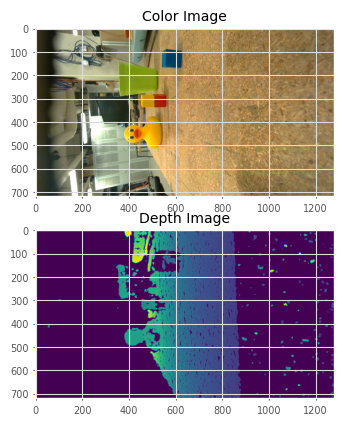

Masks


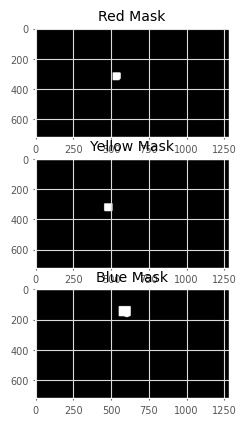

[Open3D DEBUG] Pointcloud down sampled from 1280 points to 1270 points.
[(1270, PointCloud with 1270 points.)]
[Open3D DEBUG] Pointcloud down sampled from 2131 points to 2106 points.
[(2106, PointCloud with 2106 points.)]
[Open3D DEBUG] Pointcloud down sampled from 2289 points to 1198 points.
[Open3D DEBUG] Pointcloud down sampled from 2289 points to 919 points.
[Open3D DEBUG] Pointcloud down sampled from 2289 points to 142 points.
[(1198, PointCloud with 1198 points.), (919, PointCloud with 919 points.), (142, PointCloud with 142 points.)]
redBlock:
CamFrameCoords: [[   -0.03828   -0.016335      0.2511]]
GripperFrameCoords: [  -0.016335     0.04728      0.3104]
WorldFrameCoords: [  -0.056822    -0.84426    -0.05571]
yellowBlock:
CamFrameCoords: [[  -0.060062   -0.015197      0.2454]]
GripperFrameCoords: [  -0.015197    0.069062      0.3047]
WorldFrameCoords: [  -0.056409    -0.84677    -0.03331]
blueBlock:
CamFrameCoords: [[  -0.015466    -0.06044      0.1649]]
GripperFrameCoords: [  

In [22]:
# EXPERIMENT STEP (5) - Image Measurements, Segmentation, and Processing into Blocks
urPose = ur.getPose()
pcd,rgbdImage = detector.real.getPCD()
depthImage,colorImage = rgbdImage.depth,rgbdImage.color
blocks = detector.getBlocksFromImages(colorImage,depthImage,urPose,display = True)
for block in blocks:
    print(f"{block.name}:")
    print(f"CamFrameCoords: {block.camFrameCoords}")
    print(f"GripperFrameCoords: {block.gripperFrameCoords}")
    print(f"WorldFrameCoords: {block.worldFrameCoords}")

In [23]:
# EXPERIMENT STEP (4) - Displaying PCD
detector.displayWorld(pcd,blocks)

[Open3D DEBUG] GLFW init.
[Open3D DEBUG] Add geometry and update bounding box to [(-0.0030, -0.0030, -0.0030) - (0.0500, 0.0500, 0.0500)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.2142, -0.2779, -0.0030) - (0.3861, 0.2300, 0.4995)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.2142, -0.2779, -0.0030) - (0.3861, 0.2300, 0.4995)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.2142, -0.2779, -0.0030) - (0.3861, 0.2300, 0.4995)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.2142, -0.2779, -0.0030) - (0.3861, 0.2300, 0.4995)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.2142, -0.2779, -0.0030) - (0.3861, 0.2300, 0.4995)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.2142, -0.2779, -0.0030) - (0.3861, 0.2300, 0.4995)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.2142, -0.2779, -0.0030) - (0.3861, 0.2300, 0.4995)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.2142, -0.2779, -0.

In [179]:
ur.openGripper()

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [24]:
# EXPERIMENT STEP (5) - Task Planning
planner = TaskPlanner(blocks)
goalDict = {"on":[("blueBlock","yellowBlock")]}
steps = planner.generatePlan(goalDict)
print(steps)
for block in blocks:
    print(f"{block.name} - {list(block.gripperFrameCoords)}")


<<INITIAL WORLD STATE>>
on(yellowBlock,redBlock)
clear(yellowBlock)
on(redBlock,loc-a)
on(blueBlock,loc-c)
clear(blueBlock)
fixed(loc-a)
fixed(loc-b)
clear(loc-b)
fixed(loc-c)
Domain PDDL written to domain.pddl.
Problem PDDL written to problem.pddl.
<<RUNNING FASTDOWNWARD PLANNER>>
INFO     planner time limit: None
INFO     planner memory limit: None

INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /home/dylan/.config/jupyterlab-desktop/jlab_server/bin/python3 '/home/dylan/Desktop/UR5-Interface-Linux/Final System/downward/builds/release/bin/translate/translate.py' domain.pddl problem.pddl --sas-file output.sas
Parsing...
Parsing: [0.010s CPU, 0.002s wall-clock]
Normalizing task... [0.000s CPU, 0.000s wall-clock]
Instantiating...
Generating Datalog program... [0.000s CPU, 0.001s wall-clock]
Normalizing Datalog program...
Normalizing Datalog program: [0.000s C

[[    -0.0278]
 [   -0.43338]
 [     20.052]]


In [32]:
# EXPERIMENT STEP (6) - Grasping blocks at each position in steps, returning to start position, moving to release position, moving back to start, opening gripper
sleepRate = 0.75
def projectToWorldCoords(gripperFrameCoords):
    # given a goal position in gripper coords returns the displacements from the current pose in world coords
    xB,yB,zB = gripperFrameCoords
    # subtract 0.165 from block position in gripper frame to account for gripper length
    zB -= 0.155
    currentPose = ur.getPose() #SE3 Object
    # print(f"Current Pose:\n{currentPose*1000}")
    R = currentPose.R 
    pX,pY,pZ = tuple(currentPose.t)
    # xB,yB,zB here is the block position in the gripper frame which is aligned with the optoforce frame
    P_goal = np.matmul(R,np.array([xB,yB,zB]).T)  # relative position of the block in world coordinates
    print(f"P_goal:\n{P_goal}")
    dX,dY,dZ = tuple(P_goal) # quantities and directions the the gripper frame should be incremented to be centered at the block 
    return dX,dY,dZ
    
def moveToBlock(blockPos):
    # would be better if this was block object
    # :blockPos is coord in gripper frame
    dX,dY,dZ = projectToWorldCoords(blockPos) # goalPose in world coordinates
    homePose = ur.getPose()
    dZ  += 7/1000 # up 7 mm to avoid hitting lower block
    goal1 = copy.deepcopy(homePose)
    goal1.t[2] += dZ
    ur.moveL(goal1)
    time.sleep(sleepRate)
    goal2 = goal1
    goal2.t[0] += dX
    goal2.t[1] += dY
    ur.moveL(goal2)
    time.sleep(sleepRate)
    
def moveBackFromBlock(homePose):    
    currentPose = ur.getPose()
    # Move up 3 mm to avoid raise block to prevent friction from toppling lower block
    goal1 = copy.deepcopy(currentPose)
    goal1.t[2] += 3/1000
    ur.moveL(goal1)
    time.sleep(sleepRate)
    currentPose = ur.getPose()
    dX,dY,dZ = tuple(homePose.t - currentPose.t)
    # Move in the XY Plane then Z Axis
    goal2 = copy.deepcopy(currentPose)
    goal2.t[0] += dX
    goal2.t[1] += dY
    ur.moveL(goal2)
    time.sleep(sleepRate)
    # Move in Z Axis back to home
    goal3 = copy.deepcopy(goal2)
    goal3.t[2] += dZ
    ur.moveL(goal3)
    time.sleep(sleepRate)


    
goalBlock = blocks[1]
blockLength = 0.02
releaseCoords = goalBlock.gripperFrameCoords + goalBlock.getWorldFrameVerticalInGripper(blockLength)
verticalDist = 0.02
gX,gY,gZ = tuple(goalBlock.urPose.t)
res = np.matmul(goalBlock.urPose.R,(sm.SE3.Trans([gX,gY,gZ+verticalDist]).t - goalBlock.urPose.t))
# print(f"res: {projectToWorldCoords(res)} ")
# ur.openGripper() # Open gripper
# ur.testRoutine()
# homePose = ur.getPose()
'''
for step in steps:
    # Grasp and Move Home Step
    grabPos,releasePos = step
    moveToBlock(grabPos) 
    print("Done moving to block")
    ur.closeGripper(9) 
    time.sleep(sleepRate)
    moveBackFromBlock(homePose)
    moveToBlock(releasePos)
    ur.closeGripper(55)
    moveBackFromBlock(homePose)
    ur.openGripper()
'''

P_goal:
[  0.0039764     0.14464    0.075586]
res: (0.003976396585554291, 0.14463854254200623, 0.07558585729993537) 


'\nfor step in steps:\n    # Grasp and Move Home Step\n    grabPos,releasePos = step\n    moveToBlock(grabPos) \n    print("Done moving to block")\n    ur.closeGripper(9) \n    time.sleep(sleepRate)\n    moveBackFromBlock(homePose)\n    moveToBlock(releasePos)\n    ur.closeGripper(55)\n    moveBackFromBlock(homePose)\n    ur.openGripper()\n'

In [40]:
ur.c.disconnect()
ur.r.disconnect()
time.sleep(2)
try:
    robotIP = "192.168.0.6"
    con = rtde_control.RTDEControlInterface(robotIP)
    rec = rtde_receive.RTDEReceiveInterface(robotIP)
    ur = UR5_Interface()
    ur.c = con
    ur.r = rec
    ur.gripperController = gripperController
    time.sleep(5)
    ur.testRoutine()
except Exception as e:
    raise(e)
else:
    print("UR5 + Gripper Interface Established")



Running Test Routine
Running UR Test
Running Gripper Test
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
Position of dxl ID: 1 set to 549 
Position of dxl ID: 2 set to 490 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
UR5 + Gripper Interface Established


Running Test Routine
Running UR Test
Running Gripper Test
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
Position of dxl ID: 1 set to 549 
Position of dxl ID: 2 set to 490 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [35]:
planner.locPositions["loc-a"]

{'loc-a': array([   0.050096,   -0.021586,      0.2259]),
 'loc-c': array([   -0.05287,   -0.021723,      0.2289]),
 'loc-b': array([ -0.0013869,   -0.021655,      0.2274])}

In [53]:
ur.moveL(homePose)

moveL called
poseVector = [-0.0035944035892585954, -0.5100354388254504, 0.043887949423823756, 1.6408322766858274, -0.03718901198795842, -0.05220497790293752]


RTDEControlInterface: RTDE control script is not running!


In [50]:
ur.openGripper()

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [ ]:
ur.moveL(homePose)

In [57]:
ur.openGripper()

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [136]:
# MAY WANT TO BREAK THIS UP INTO SEPARATE CELLS
def runRoutine():
    print("1")
    try:
        ur = UR5_Interface()
        ur.c = con
        ur.r = rec
        ur.gripperController = gripperController
    except Exception as e:
        raise(e)
        
    print("2")
    # robot_model = RTB_Model()
    # robot_model.setJointAngles(ur.getJointAngles())
    # Set joint angles so object detection has correct extrinsics
    
    # Instantiates ObjectDetection object which intializes a connection to the realsense
    detector = ObjectDetection(robot_model,moveRelative = True)
    
    try:
        
        ur.openGripper()
        print(f"Nth Frame Pose:\n{np.array(ur.getPose())}")
        # Takes images for display
        pcd,rgbdImage = detector.real.getPCD()
        depthImage,colorImage = rgbdImage.depth,rgbdImage.color
        # detector.real.displayImages(depthImage,colorImage)
        
        blocks = detector.getBlocksFromImages(colorImage,depthImage)
        for block in blocks:
            print(f"{block.name}:")
            print(f"CamFrameCoords: {block.camFrameCoords}")
            print(f"GripperFrameCoords: {block.gripperFrameCoords}")
            print(f"WorldFrameCoords: {block.worldFrameCoords}")
        m = MotionPlanner(blocks,moveRelative = True)
        # Interface to the UR5
        m.ur = ur 
        # m.rtb_model = robot_model
        redBlock,yellowBlock,blueBlock = blocks
        redPCD,yellowPCD,bluePCD = redBlock.blockPCD,yellowBlock.blockPCD,blueBlock.blockPCD
        redAABB,yellowAABB,blueAABB = redBlock.blockAABB,yellowBlock.blockAABB,blueBlock.blockAABB,
        detector.real.displayPCD([redPCD,yellowPCD,bluePCD,redAABB,yellowAABB,blueAABB])
        m.runMovement()
        # time.sleep(3)
        # ur.closeGripper(10)
        
    except Exception as e:
        raise(e)
    finally:
        detector.real.pipe.stop()
        # ur.c.disconnect()
        # ur.r.disconnect()
runRoutine()

1
2


NameError: name 'robot_model' is not defined

In [84]:
ur.c.disconnect()
ur.r.disconnect()

robot_model = RTB_Model()
robot_model.plotRobot()
x,y,z = [],[],[]
for point in redPCD.points:
    x.append(point[0])
    y.append(point[1])
    z.append(point[2])

print(np.mean(x))
print(np.mean(y))
print(np.mean(z))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
plt.show()

In [ ]:
(real.extrinsics is None) == False